Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [2]:
NAME = "Piotr Durniat"

In [9]:
import os
os.chdir("/root")

---

# 3. Uczenie nienadzorowane

W poprzednim zeszycie zbadaliśmy różne modele grafowych sieci neuronowych w scenariuszu nadzorowanej klasyfikacji wierzchołków. Teraz zajmiemy się tematem uczenia nienadzorowanego dla GNNów, który jak już wcześniej wspomnieliśmy, jest trochę bardziej złożony.

W jaki sposób powinna być skonstruowana funkcja kosztu? Czy możemy zastosować model autokodera? Jak w takim razie powinien działać dekoder? Jak uwzględnić relacje między wierzchołkami?

To tylko kilka pytań, na które należy odpowiedzieć podczas opracowania nienadzorowanego modelu grafowych sieci neuronowych. W ostatnich latach powstało wiele rozwiązań, obejmujących między innymi:
- grafowe autokodery (w tym wariacyjne)
- uczenie kontrastowe
- uczenie samo-nadzorowane

W ninejszym zeszycie najpierw zbadamy **model grafowego autokodera** jako najprostszego modelu stosowanego w nienadzorowanym uczeniu reprezentacji grafów, a następnie zbadamy **model Graph Barlow Twins**.

## 3.1. Grafowy autokoder
W 2016 roku Kipf, autor pracy wprowadzającej architekturę GCN, opublikował również [artykuł](https://arxiv.org/pdf/1611.07308.pdf) w którym pokazał jak wykorzystać GCNa (lub dowolny inny GNNowy model) w znanej nam architekturze autokodera. Jak wiemy taki model składa się z dwóch komponentów:
- **kodera** - w tym wypadku koderem jest wybrana przez nas grafowa sieć neuronowa

$$\mathbf{Z} = \text{GNN}(\mathbf{X}, \mathbf{A})$$

- **dekodera** - model dekodera na wejściu przyjmuje wyznaczone reprezentacje $\mathbf{Z}$, a na wyjściu oblicza rekonstrukcję danego obiektu, w naszym przypadku grafu. Jednak co dokładnie powinien odtworzyć taki grafowy dekoder? Strukturę, atrybuty, czy jedno i drugie? W swojej pracy Kipf zaproponował, aby skupić się wyłącznie na strukturze grafu, tzn. dokonać rekonstrukcji krawędzi. Taki wariant również będziemy rozważać na cele tego laboratorium, przy czym inne scenariusze są równie poprawne i w zależności od konkretnego zadania mogą dostarczać lepszych wyników. 

W celu zbudowania odpowiedniego dekodera strukturalnego musimy określić w jaki sposób będziemy decydować czy istnieje krawędź między parą dowolnych wierzchołków. Najpopularniejszym rozwiązaniem jest wykorzystanie iloczynu skalarnego, podobnie jak w przypadku modelu Node2vec definiowaliśmy podobieństwo wierzchołków w przestrzeni reprezentacji. Tutaj wybór ten jest umotywowany intuicją, że podobne wierzchołki powinny być połączone krawędzią. Dekoder ma zatem postać:

$$\hat{\mathbf{A}} = \sigma(\mathbf{Z}\mathbf{Z}^T),$$

gdzie:
- $\hat{\mathbf{A}}$ to rekonstrukcja macierzy sąsiedztwa
- $\sigma(\cdot)$ to sigmoidalna funkcja aktywacji

## Zadanie 3.1. (4 pkt)
Wykorzystując zaimplementowane w PyTorch-Geometricu modele:
- grafowego autokodera `GAE` - [link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAE.html)
- dekodera iloczynu skalarnego `InnerProductDecoder` - [link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.InnerProductDecoder.html)

dokończ implementację klasy `BaseUnsupervisedGNN` oraz `GraphAutoencoder`. Zastosuj się do komentarzy umieszczonych przy odpowiednich funkcjach.

In [3]:
import pytorch_lightning as pl
import torch
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from torch import nn
from torch_geometric.data import Data


class BaseUnsupervisedGNN(pl.LightningModule):
    """Base class for unsupervised GNN models for node representations."""

    def __init__(self):
        super().__init__()

        self._downstream_model = None
        self.training_step_outputs = []

    def on_train_batch_end(self, outputs, batch, batch_idx) -> None:
        self.training_step_outputs.append(outputs)

    def on_validation_epoch_start(self) -> None:
        z_train = torch.cat(
            [out["z_train"].detach() for out in self.training_step_outputs], dim=0
        )
        y_train = torch.cat(
            [out["y_train"] for out in self.training_step_outputs], dim=0
        )
        z_train, y_train = z_train.cpu(), y_train.cpu()
        self.training_step_output = []

        # TODO: Naucz model regresji logistycznej na parach (`z_train`, `y_train`),
        # a następnie oblicz wartość miary AUC na zbiorze treningowym. Wykorzystaj
        # model regresji logistycznej z biblioteki Scikit-Learn i przypisz go do
        # pola: `self._downstream_model`.

        # TU WPISZ KOD
        self._downstream_model = LogisticRegression()
        self._downstream_model.fit(z_train, y_train)
        y_pred = self._downstream_model.predict_proba(z_train)
        auc = roc_auc_score(y_train, y_pred, multi_class="ovr")

        self.log("train/auc", auc, on_epoch=True, on_step=False)

    def validation_step(self, batch: Data, batch_idx: int):
        auc = self._compute_auc(data=batch, mask=batch.val_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("val/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def test_step(self, batch: Data, batch_idx: int):
        auc = self._compute_auc(data=batch, mask=batch.test_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("test/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def predict_step(
        self,
        batch: Data,
        batch_idx: int,
        dataloader_idx: int | None = None,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        z = self(batch.x, batch.edge_index)
        y = batch.y

        return z, y

    def _compute_auc(self, data: Data, mask: torch.Tensor) -> float:
        # TODO: Oblicz wartość miary AUC dla zadanego przez maskę
        # podzbioru wierzchołków.

        # TU WPISZ KOD
        y_true = data.y[mask].cpu().numpy()
        self.eval()
        with torch.no_grad():
            z_true = self(data.x, data.edge_index)[mask].cpu().numpy()
        y_pred = self._downstream_model.predict_proba(z_true)
        auc = roc_auc_score(y_true, y_pred, multi_class="ovr")
        return auc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            params=self.parameters(),
            lr=1e-3,
            weight_decay=5e-4,
        )

In [4]:
from torch_geometric.nn.models import GAE


class GraphAutoencoder(BaseUnsupervisedGNN):
    """Unsupervised graph autoencoder for node representations."""

    def __init__(self, gnn: nn.Module):
        super().__init__()

        # TODO: Utwórz model GAE
        # TU WPISZ KOD
        self.gae = GAE(gnn)

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        # TODO: Funkcja forward powinna zwracać wektory reprezentacji `z`
        # TU WPISZ KOD
        return self.gae(x, edge_index)

    def training_step(self, batch: Data, batch_idx: int) -> dict:
        # TODO: Wyznacz wektory reprezentacji `z` oraz oblicz funkcję kosztu `loss`
        # TU WPISZ KOD
        z = self.forward(batch.x, batch.edge_index)
        loss = self.gae.recon_loss(z, batch.edge_index)

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", loss.item(), on_epoch=True, on_step=False)

        return {
            "loss": loss,
            "z_train": z[batch.train_mask],
            "y_train": batch.y[batch.train_mask],
        }

In [10]:
from torch_geometric.datasets import Planetoid
from torch_geometric.data.lightning import LightningNodeData

dataset = Planetoid(root="./data", name="Cora")

datamodule = LightningNodeData(
    data=dataset[0],
    loader="full",
)

Dla wszystkich modeli zdefiniujmy sobie zbiór wspólnych hiperparametrów:

In [11]:
hparams = {
    "num_epochs": 10,
    "hidden_dim": 256,
    "emb_dim": 128,
}
ACCELERATOR = "gpu"  # change to "cuda" in order to use GPU

Porównamy teraz jakość działania modeli GNNowych, wprowadzonych w poprzednim zeszycie:

In [12]:
from torch import nn
from torch_geometric.nn import GATConv, GCNConv, SAGEConv


class GCNEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


class GATEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=1)
        self.act1 = nn.ReLU()
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ./data/logs/gae_GCN
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | gae  | GAE  | 400 K 
------------------------------
400 K     Trainable params
0         Non-trainable params
400 K     Total params
1.600     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

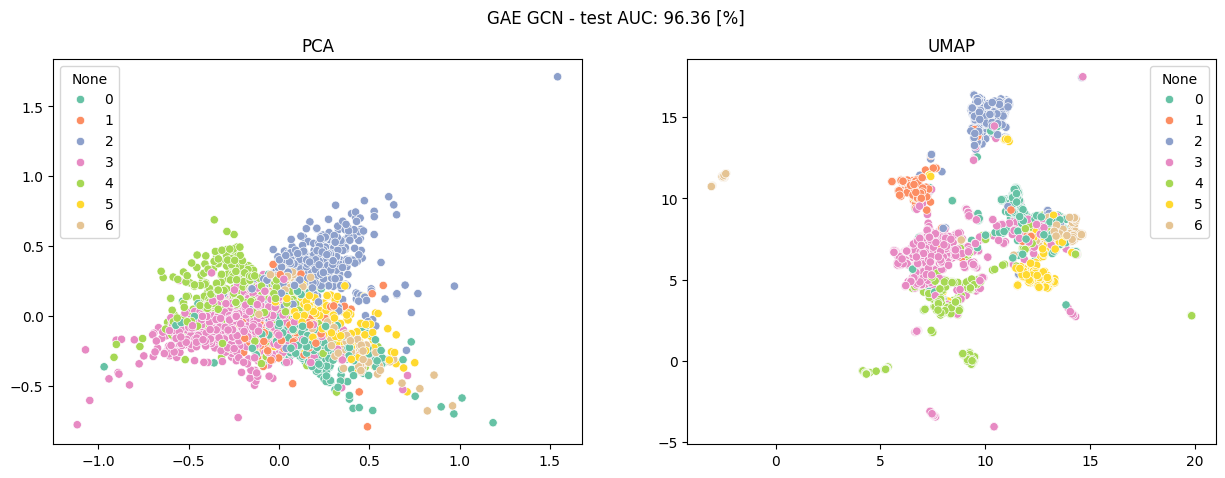

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/gae_GraphSAGE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | gae  | GAE  | 799 K 
------------------------------
799 K     Trainable params
0         Non-trainable params
799 K     Total params
3.198     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

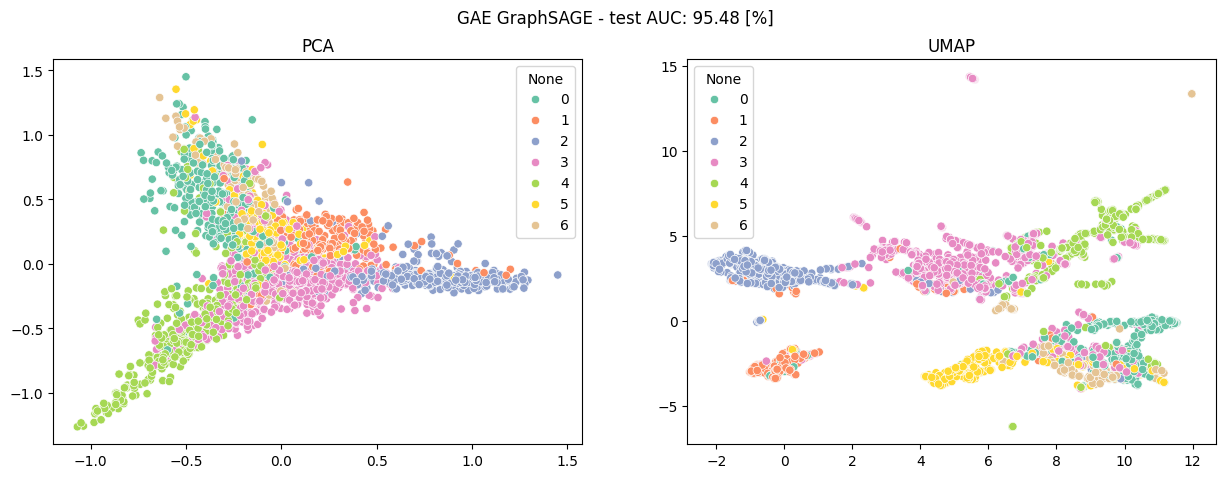

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/gae_GAT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | gae  | GAE  | 400 K 
------------------------------
400 K     Trainable params
0         Non-trainable params
400 K     Total params
1.603     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

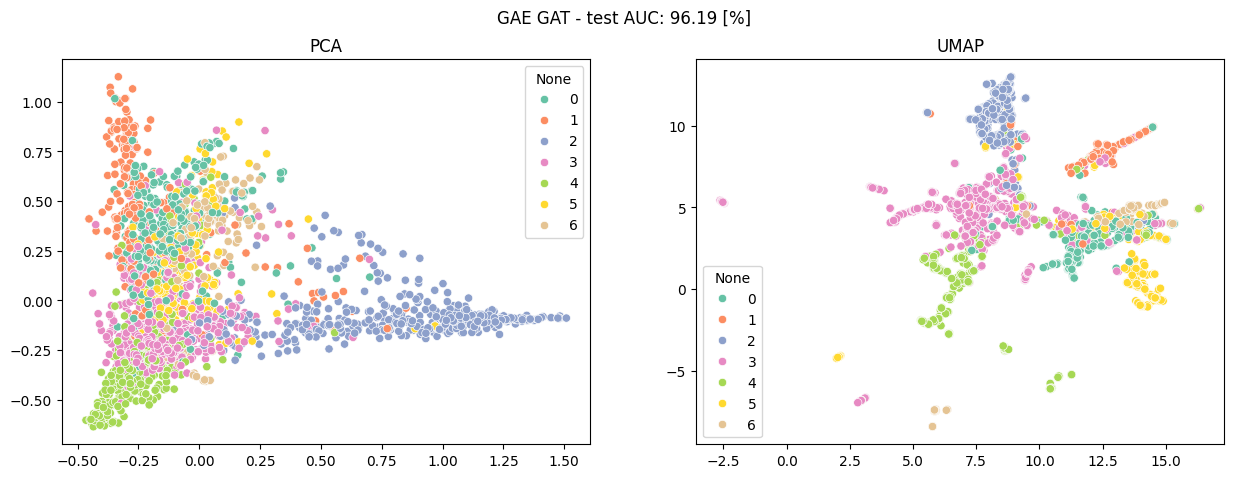

In [13]:
import matplotlib.pyplot as plt

from src.trainer import get_default_trainer
from src.utils import visualize_embeddings


def evaluate_unsupervised_models():
    scenarios = [
        ("GCN", GCNEncoder),
        ("GraphSAGE", GraphSAGEEncoder),
        ("GAT", GATEncoder),
    ]

    for model_name, gnn_cls in scenarios:
        gnn = gnn_cls(
            in_dim=datamodule.data.num_node_features,
            hidden_dim=hparams["hidden_dim"],
            out_dim=hparams["emb_dim"],
        )

        model = GraphAutoencoder(gnn=gnn)

        trainer = get_default_trainer(
            num_epochs=hparams["num_epochs"],
            model_name=f"gae_{model_name}",
            accelerator=ACCELERATOR,
        )

        trainer.fit(model=model, datamodule=datamodule)

        test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
            "test/auc"
        ]
        z, y = trainer.predict(model=model, datamodule=datamodule)[0]
        z, y = z.cpu(), y.cpu()

        fig = visualize_embeddings(z=z, y=y)
        fig.suptitle(f"GAE {model_name} - test AUC: {test_auc * 100.:.2f} [%]")

        plt.show()


evaluate_unsupervised_models()

In [14]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs/ --port 6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E0529 19:44:56.662982 140127101952000 program.py:300] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

## 3.2. Graph Barlow Twins

Grafowe autokodery są obecnie już rzadko stosowane i zostały zastąpione przez modele należące do metod samonadzorowanych (ang. *self-supervised*). Jednym z przykładów jest model stanowiący rozszerzenie modelu Barlow Twins na dziedzinę grafów – [**Graph Barlow Twins**](https://arxiv.org/abs/2106.02466). Potok przetwarzania został przedstawiony na rysunku poniżej:

![](./assets/graph-barlow-twins.png)

Dla zadanego grafu wejściowego $\mathcal{G}$ tworzone są dwa zmodyfikowane widoki $\mathcal{G}^{(1)}, \mathcal{G}^{(2)}$ za pomocą funkcji augmentacji (tutaj: losowe usuwanie krawędzi oraz maskowanie atrybutów wierzchołków). Następnie oba widoki są przetwarzane przez ten sam moduł kodera GNN, w wyniku czego otrzymujemy dwa zestawy (dwie macierze) reprezentacji wierzchołków $Z^{(1)}, Z^{(2)}$. Dla tych macierzy liczymy macierz korelacji wzajemnej $\mathcal{C}$:

$$\mathcal{C}_{ij} = \frac{\sum_b Z^{(1)}_{b,i} Z^{(2)}_{b,j}}{\sqrt{\sum_b (Z^{(1)}_{b,i})^2} \sqrt{\sum_b (Z^{(2)}_{b,j})^2}} $$

Model jest uczony za pomocą funkcji kosztu, która zbliża wartości w macierzy korelacji wzajemnej do macierzy jednostkowej:

$$\mathcal{L}_\text{BT} = \sum_i (1 - C_{ii})^2 + \lambda\sum_i\sum_{j \ne i} C_{ij}^2$$

## Zadanie 3.2 (1 pkt)
Dokończ implementację modelu Graph Barlow Twins

In [15]:
import torch
from torch_geometric.data import Data


class GraphAugmentor:
    """Masks node features (same for all nodes) and drops edges."""

    def __init__(self, p_x: float, p_e: float):
        self._p_x = p_x
        self._p_e = p_e

    def __call__(self, data: Data):
        x_a = mask_features(data.x, p=self._p_x)
        x_b = mask_features(data.x, p=self._p_x)

        edge_index_a = drop_edges(data.edge_index, p=self._p_e)
        edge_index_b = drop_edges(data.edge_index, p=self._p_e)

        return (x_a, edge_index_a), (x_b, edge_index_b)


def mask_features(x: torch.Tensor, p: float) -> torch.Tensor:
    num_features = x.size(-1)
    device = x.device

    return bernoulli_mask(size=(1, num_features), prob=p).to(device) * x


def drop_edges(edge_index: torch.Tensor, p: float) -> torch.Tensor:
    num_edges = edge_index.size(-1)
    device = edge_index.device

    mask = bernoulli_mask(size=num_edges, prob=p).to(device) == 1.0

    return edge_index[:, mask]


def bernoulli_mask(size: int | tuple[int, ...], prob: float):
    return torch.bernoulli((1 - prob) * torch.ones(size))

In [16]:
import torch

EPS = 1e-15


def barlow_twins_loss(
    z_a: torch.Tensor,
    z_b: torch.Tensor,
) -> torch.Tensor:
    batch_size = z_a.size(0)
    feature_dim = z_a.size(1)
    _lambda = 1 / feature_dim

    # Apply batch normalization
    z_a_norm = (z_a - z_a.mean(dim=0)) / (z_a.std(dim=0) + EPS)
    z_b_norm = (z_b - z_b.mean(dim=0)) / (z_b.std(dim=0) + EPS)

    # Cross-correlation matrix
    c = (z_a_norm.T @ z_b_norm) / batch_size

    # Loss function
    off_diagonal_mask = ~torch.eye(feature_dim).bool()
    loss = (1 - c.diagonal()).pow(2).sum() + _lambda * c[off_diagonal_mask].pow(2).sum()

    return loss

In [17]:
class GCNEncoderBN(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(
            hidden_dim, momentum=0.01
        )  # same as `weight_decay = 0.99`
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.bn1(self.conv1(x, edge_index)))
        z = self.act2(self.conv2(z, edge_index))
        return z


class GraphSAGEEncoderBN(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(
            hidden_dim, momentum=0.01
        )  # same as `weight_decay = 0.99`
        self.act1 = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.bn1(self.conv1(x, edge_index)))
        z = self.act2(self.conv2(z, edge_index))
        return z


class GATEncoderBN(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=1)
        self.bn1 = nn.BatchNorm1d(
            hidden_dim, momentum=0.01
        )  # same as `weight_decay = 0.99`
        self.act1 = nn.ReLU()
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.bn1(self.conv1(x, edge_index)))
        z = self.act2(self.conv2(z, edge_index))
        return z

In [18]:
class GraphBarlowTwins(BaseUnsupervisedGNN):
    """Self-supervised Barlow Twins model for graphs."""

    def __init__(self, encoder: nn.Module, p_x: float, p_e: float):
        super().__init__()

        self.augmentor = GraphAugmentor(p_x=p_x, p_e=p_e)
        self.encoder = encoder

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        return self.encoder(x, edge_index)

    def training_step(self, batch: Data, batch_idx: int) -> dict:
        # Uzupełnij potok przetwarzania modelu GBT, aby obliczyć wartość funkcji kosztu `loss`

        # TU WPISZ KOD
        (x_a, edge_index_a), (x_b, edge_index_b) = self.augmentor(batch)
        z_a = self(x=x_a, edge_index=edge_index_a)
        z_b = self(x=x_b, edge_index=edge_index_b)
        loss = barlow_twins_loss(z_a, z_b)

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", loss.item(), on_epoch=True, on_step=False)

        z = self(x=batch.x, edge_index=batch.edge_index)

        return {
            "loss": loss,
            "z_train": z[batch.train_mask],
            "y_train": batch.y[batch.train_mask],
        }

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/gbt_base_GCN
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | encoder | GCNEncoderBN | 400 K 
-----------------------------------------
400 K     Trainable params
0         Non-trainable params
400 K     Total params
1.602     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

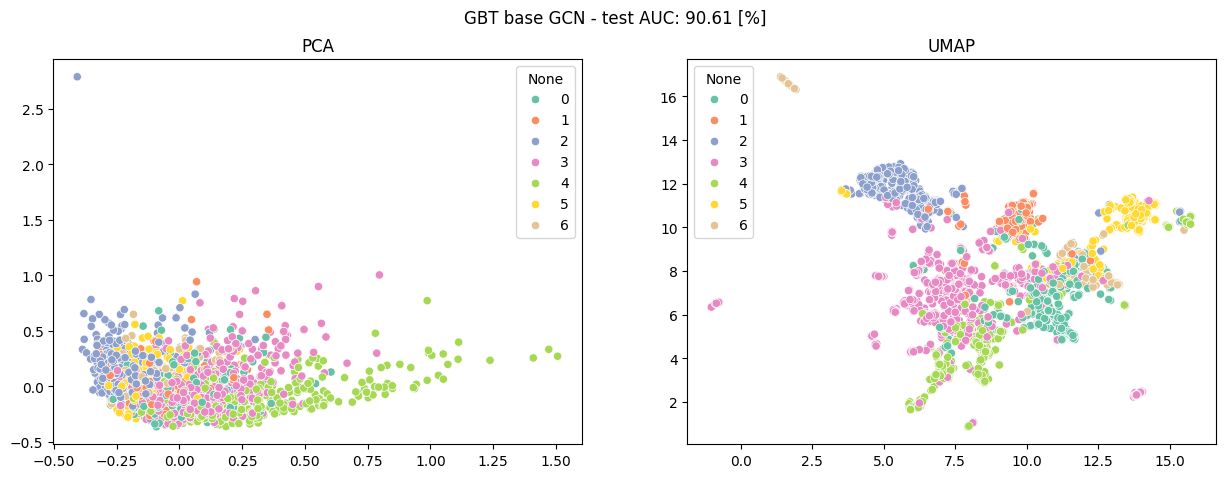

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/gbt_base_GraphSAGE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | GraphSAGEEncoderBN | 800 K 
-----------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

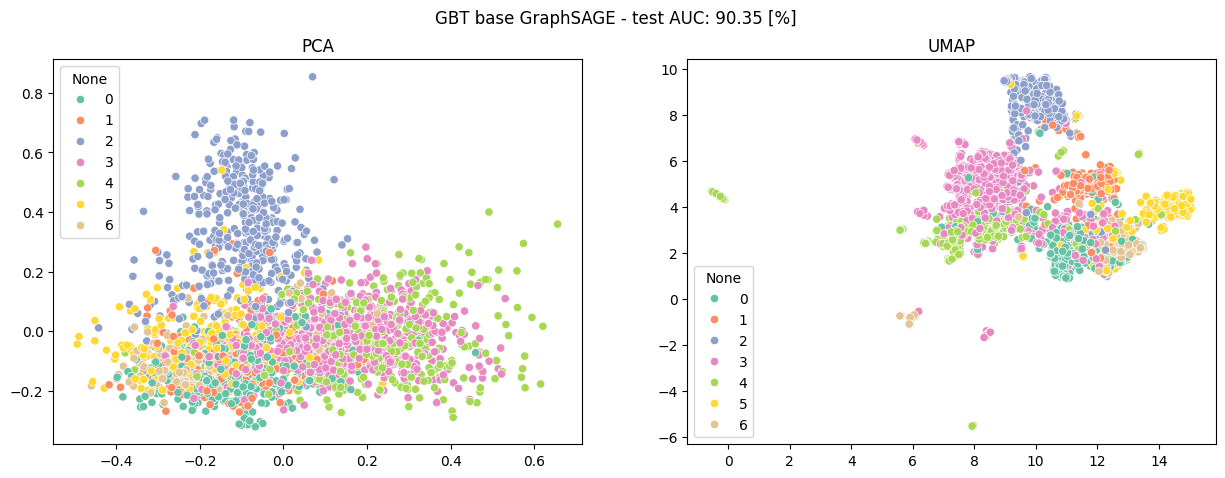

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./data/logs/gbt_base_GAT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | encoder | GATEncoderBN | 401 K 
-----------------------------------------
401 K     Trainable params
0         Non-trainable params
401 K     Total params
1.605     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

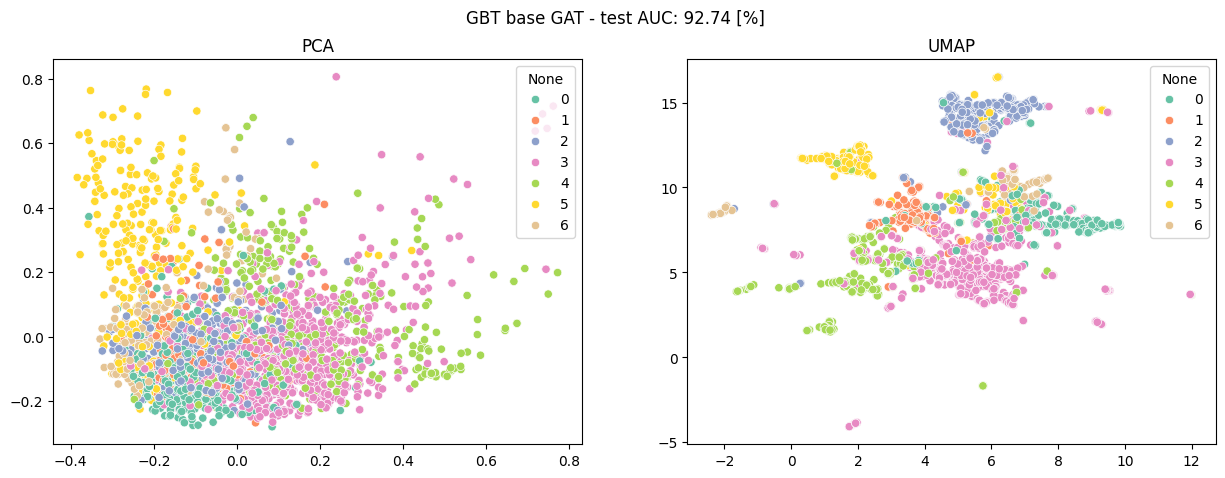

In [19]:
def evaluate_gbt_models():
    scenarios = [
        ("GCN", GCNEncoderBN),
        ("GraphSAGE", GraphSAGEEncoderBN),
        ("GAT", GATEncoderBN),
    ]

    for model_name, gnn_cls in scenarios:
        gnn = gnn_cls(
            in_dim=datamodule.data.num_node_features,
            hidden_dim=hparams["hidden_dim"],
            out_dim=hparams["emb_dim"],
        )

        model = GraphBarlowTwins(encoder=gnn, p_x=0.2, p_e=0.4)

        trainer = get_default_trainer(
            num_epochs=hparams["num_epochs"],
            model_name=f"gbt_base_{model_name}",
            accelerator=ACCELERATOR,
        )

        trainer.fit(model=model, datamodule=datamodule)

        test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0][
            "test/auc"
        ]
        z, y = trainer.predict(model=model, datamodule=datamodule)[0]
        z, y = z.cpu(), y.cpu()

        fig = visualize_embeddings(z=z, y=y)
        fig.suptitle(f"GBT base {model_name} - test AUC: {test_auc * 100.:.2f} [%]")

        plt.show()


evaluate_gbt_models()

## Zadanie 3.3 (2 pkt)
Zbadaj wpływ hiperparametrów maskowania atrybutów wierzchołków `p_x` oraz usuwania krawędzi `p_e` na jakość reprezentacji:
- wybierz kilka (min. 4) wartości dla każdego hiperparametru
- zewaluuj model dla iloczynu kartezjańskiego tych hiperparametrów
- każdy eksperyment powtórz min. 2 razy
- w tabelce lub na wykresie przedstaw jak dane hiperparametry wpływały na jakość reprezentacji w zadaniu docelowym

In [24]:
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from typing import Any


def initialize_parameters() -> tuple[int, list[float], list[float], list[tuple[float, float]], list[tuple[str, Type]]]:
    num_repeats = 10
    px_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    pe_values = [0.1, 0.3, 0.5, 0.7, 0.9]
    param_combinations = list(product(px_values, pe_values))
    model_scenarios = [
        ("GCN", GCNEncoderBN),
        ("GraphSAGE", GraphSAGEEncoderBN),
        ("GAT", GATEncoderBN),
    ]
    return num_repeats, px_values, pe_values, param_combinations, model_scenarios


def evaluate_model_scenarios(
    model_scenarios: list[tuple[str, Type]],
    param_combinations: list[tuple[float, float]],
    px_values: list[float],
    pe_values: list[float],
    datamodule: Any,
    hparams: dict[str, Any],
    quiet: bool,
    num_repeats: int
) -> dict[str, dict[str, float]]:
    best_params_dict = {}
    for model_name, gnn_class in model_scenarios:
        gnn_instance = gnn_class(
            in_dim=datamodule.data.num_node_features,
            hidden_dim=hparams["hidden_dim"],
            out_dim=hparams["emb_dim"],
        )
        best_z, best_y, best_auc, best_px, best_pe = (
            None,
            None,
            -np.inf,
            -np.inf,
            -np.inf,
        )
        auc_matrix = np.zeros((len(px_values), len(pe_values)))

        for px, pe in param_combinations:
            model_instance = GraphBarlowTwins(encoder=gnn_instance, p_x=px, p_e=pe)
            trainer = get_default_trainer(
                num_epochs=hparams["num_epochs"],
                model_name=f"gbt_base_{model_name}",
                accelerator=ACCELERATOR,
                quiet=quiet,
            )
            cumulative_auc = 0
            for _ in range(num_repeats):
                trainer.fit(model=model_instance, datamodule=datamodule)
                cumulative_auc += trainer.test(
                    model=model_instance, datamodule=datamodule, verbose=False
                )[0]["test/auc"]
                z, y = trainer.predict(model=model_instance, datamodule=datamodule)[0]
                z, y = z.cpu(), y.cpu()

            average_auc = cumulative_auc / num_repeats
            auc_matrix[px_values.index(px)][pe_values.index(pe)] = average_auc
            if average_auc > best_auc:
                best_auc = average_auc
                best_px = px
                best_pe = pe
                best_z = z
                best_y = y

        best_params_dict[model_name] = {"p_x": best_px, "p_e": best_pe, "auc": best_auc}
        plot_auc_results(
            px_values,
            pe_values,
            auc_matrix,
            best_px,
            best_pe,
            best_auc,
            best_z,
            best_y,
            model_name,
        )
    return best_params_dict


def plot_auc_results(
    px_values: list[float],
    pe_values: list[float],
    auc_matrix: np.ndarray,
    best_px: float,
    best_pe: float,
    best_auc: float,
    best_z: torch.Tensor,
    best_y: torch.Tensor,
    model_name: str,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    X, Y = np.meshgrid(np.array(px_values), np.array(pe_values))
    Z = auc_matrix

    ax = axs[0]
    ax = fig.add_subplot(121, projection="3d")
    surf = ax.plot_surface(
        X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False
    )
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.set_title("Surface Plot")
    ax.set_xlabel("p_x")
    ax.set_ylabel("p_e")
    ax.set_zlabel("AUC")

    ax = axs[1]
    levels = np.linspace(np.min(Z), np.max(Z), 10)
    ax.contour(X, Y, Z, levels=levels)
    ax.scatter(best_px, best_pe, marker="o", color="red", s=9, label="best auc")
    ax.legend()
    ax.set_title("Contour Plot")
    ax.set_xlabel("p_x")
    ax.set_xlim(0.08, 0.92)
    ax.set_ylabel("p_e")
    ax.set_ylim(0.08, 0.92)

    fig.suptitle(
        f"GBT base {model_name} - test AUC = {best_auc * 100.:.2f} [%]\n for p_x = {best_px} and p_e = {best_pe}",
        fontsize=15,
    )
    plt.show()

    fig2 = visualize_embeddings(z=best_z, y=best_y)
    fig2.suptitle(f"GBT base {model_name} - test AUC: {best_auc * 100.:.2f} [%]")
    plt.show()


def tune_gbt(quiet: bool = True) -> dict[str, dict[str, float]]:
    num_repeats, px_values, pe_values, param_combinations, model_scenarios = initialize_parameters()
    best_params_dict = evaluate_model_scenarios(
        model_scenarios,
        param_combinations,
        px_values,
        pe_values,
        datamodule,
        hparams,
        quiet,
        num_repeats,
    )
    return best_params_dict


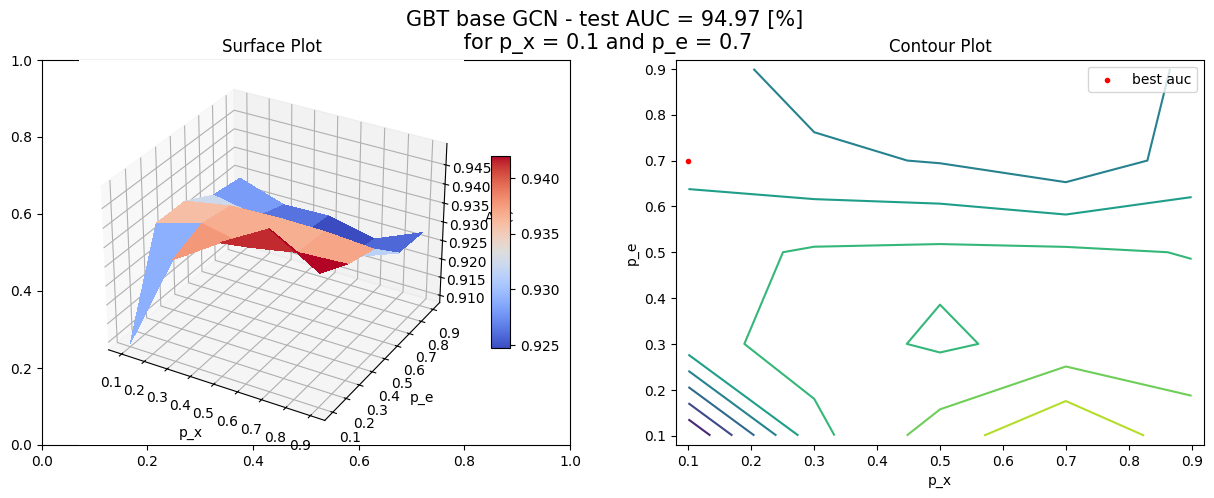

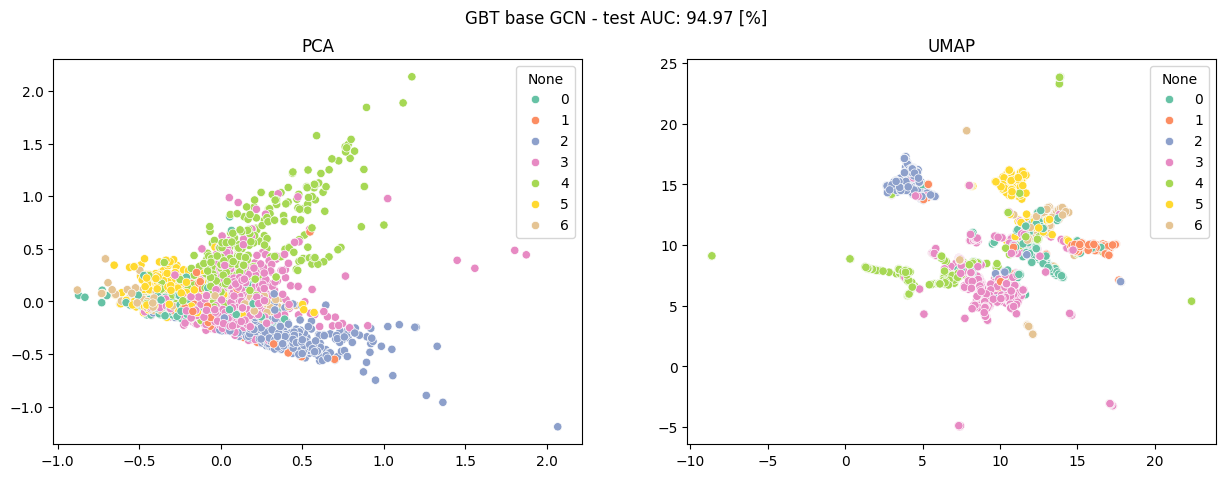

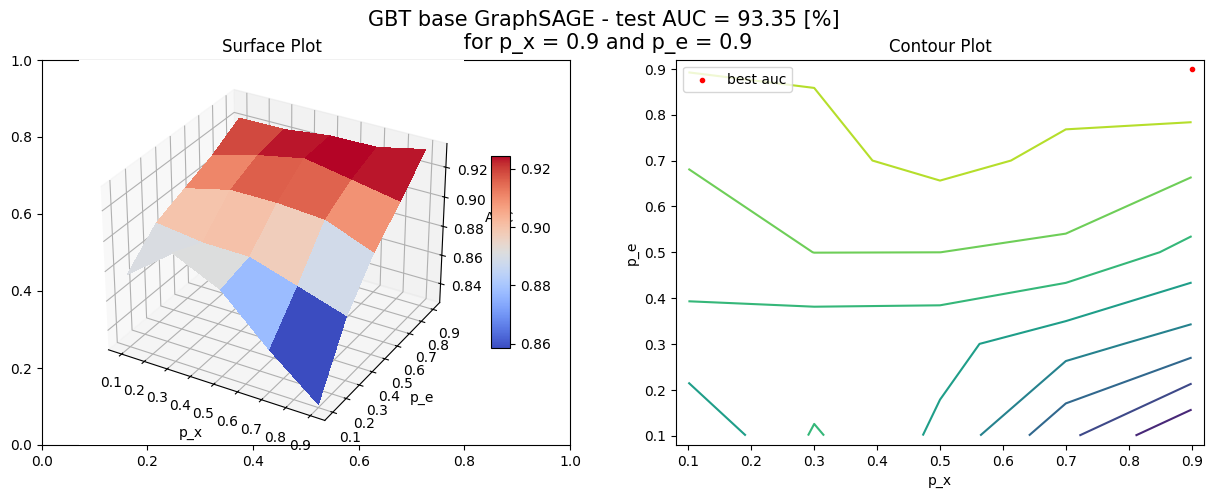

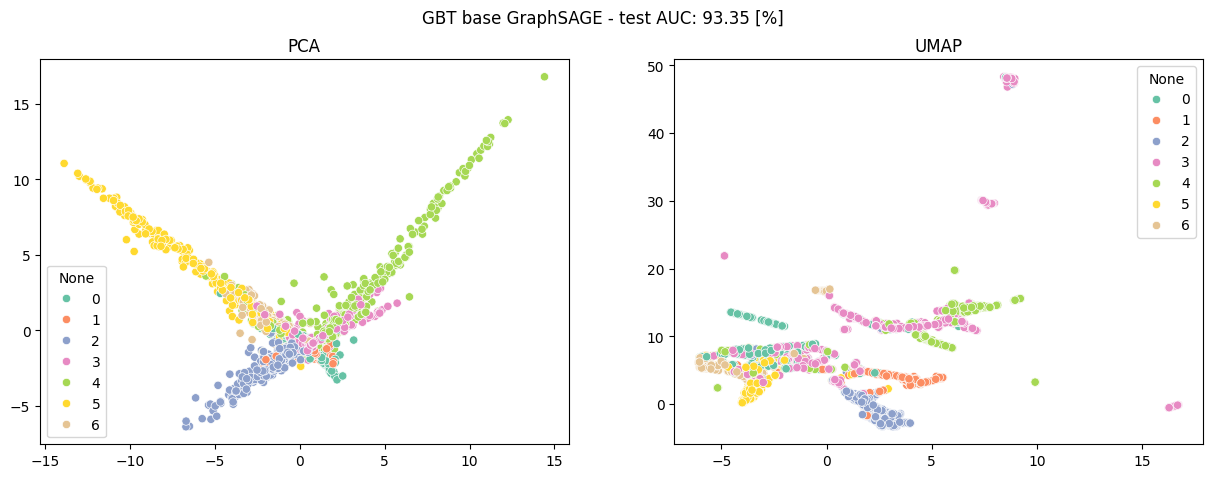

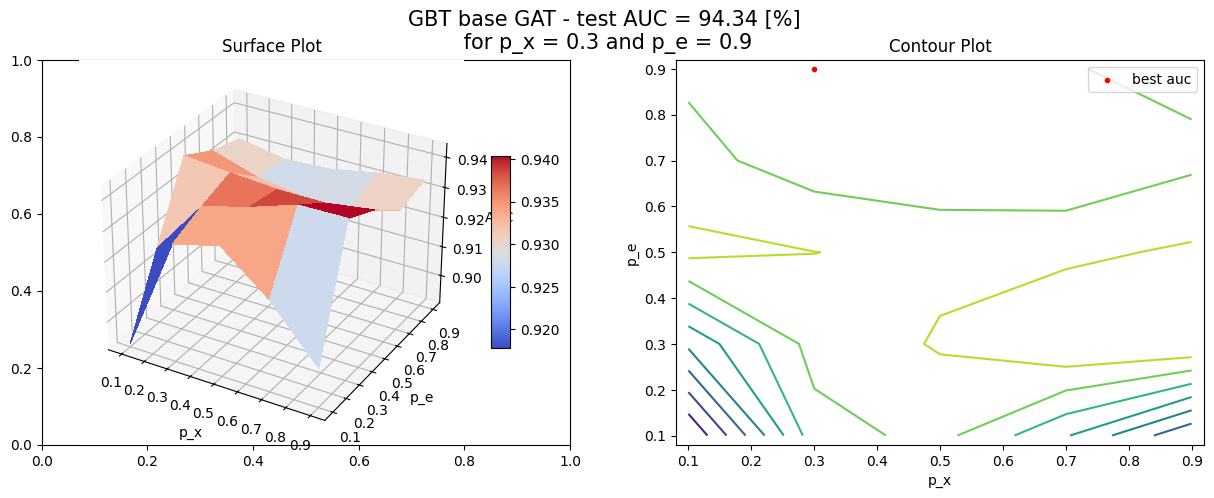

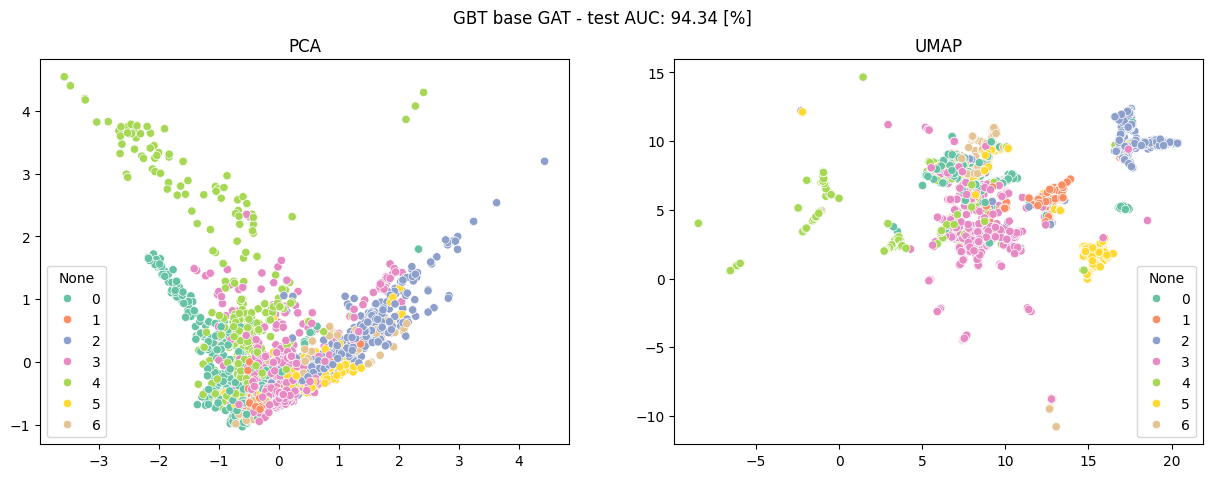

{'GCN': {'p_x': 0.1, 'p_e': 0.7, 'auc': 0.9496685922145843},
 'GraphSAGE': {'p_x': 0.9, 'p_e': 0.9, 'auc': 0.9334854483604431},
 'GAT': {'p_x': 0.3, 'p_e': 0.9, 'auc': 0.9433701694011688}}

In [25]:
params = tune_gbt(quiet=True)
display(params)

## Zadanie 3.4 (1 pkt)
Zbadaj wpływ normalizacji `BatchNorm` na jakość reprezentacji:
- korzystając z wyników z poprzedniego zadania, wybierz najlepszy zestaw hiperparametrów `p_x` i `p_e`
- zewaluuj model z użyciem kodera GNNowego, który nie używa batch normalizacji 
- każdy eksperyment powtórz min. 2 razy
- w tabelce lub na wykresie przedstaw jak użyte kodery wpływały na jakość reprezentacji w zadaniu docelowym

In [48]:
from copy import deepcopy

def eval_no_batchnorm(params: dict, silent: bool = True):

    num_repeats = 10
    model_scenarios = [
        ("GCN", GCNEncoder),
        ("GraphSAGE", GraphSAGEEncoder),
        ("GAT", GATEncoder),
    ]  
    auc_results = deepcopy(params)
    auc_results = {key: (val.popitem() and val) for key, val in auc_results.items()}
    
    for model_name, encoder_class in model_scenarios:
        encoder = encoder_class(
            in_dim=datamodule.data.num_node_features,
            hidden_dim=hparams["hidden_dim"],
            out_dim=hparams["emb_dim"],
        )
        
        p_x, p_e = list(auc_results[model_name].values())
        model = GraphBarlowTwins(encoder=encoder, p_x=p_x, p_e=p_e)
        
        trainer = get_default_trainer(
            num_epochs=hparams["num_epochs"],
            model_name=f"gbt_base_{model_name}",
            accelerator=ACCELERATOR,
            quiet=silent
        )

        accumulated_auc = 0
        for _ in range(num_repeats):
            trainer.fit(model=model, datamodule=datamodule)
            accumulated_auc += trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
            embeddings, labels = trainer.predict(model=model, datamodule=datamodule)[0]
            embeddings, labels = embeddings.cpu(), labels.cpu()
        avg_auc = accumulated_auc / num_repeats
        auc_results[model_name]['auc'] = avg_auc

        fig = visualize_embeddings(z=embeddings, y=labels)
        fig.suptitle(f"GBT base {model_name} - test AUC: {avg_auc * 100.:.2f} [%]")
        plt.show()
        
    return auc_results


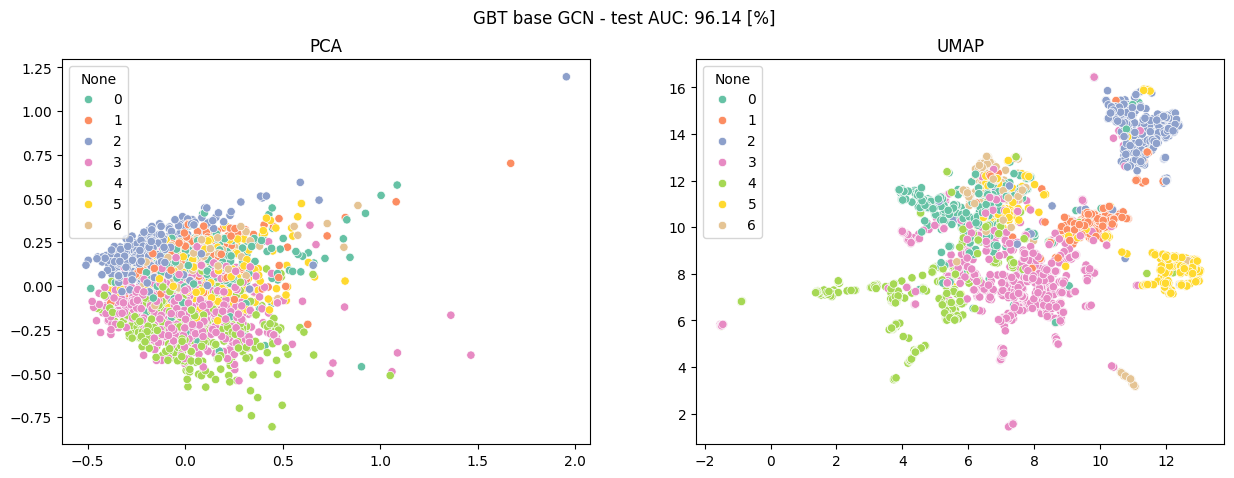

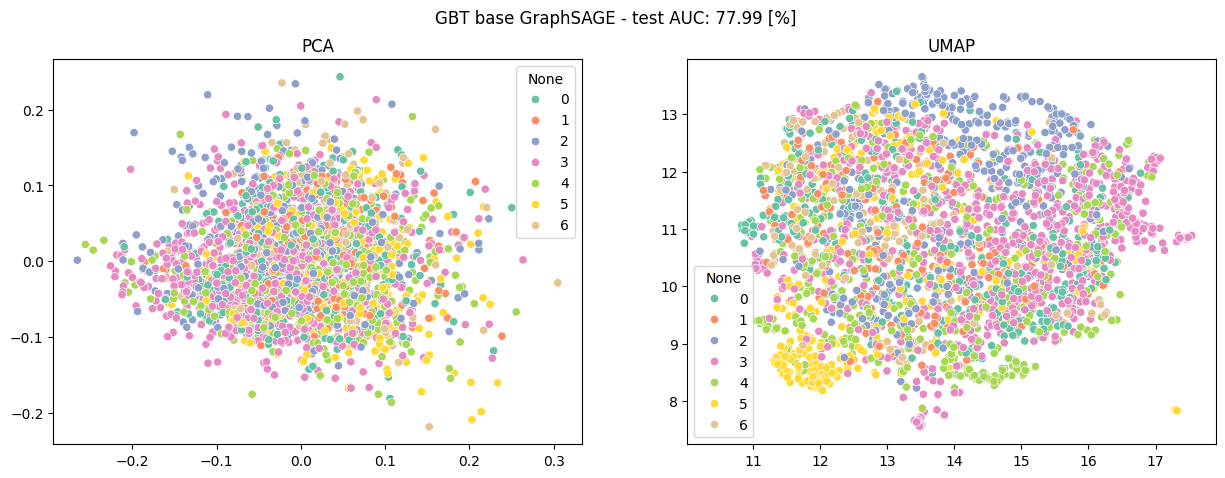

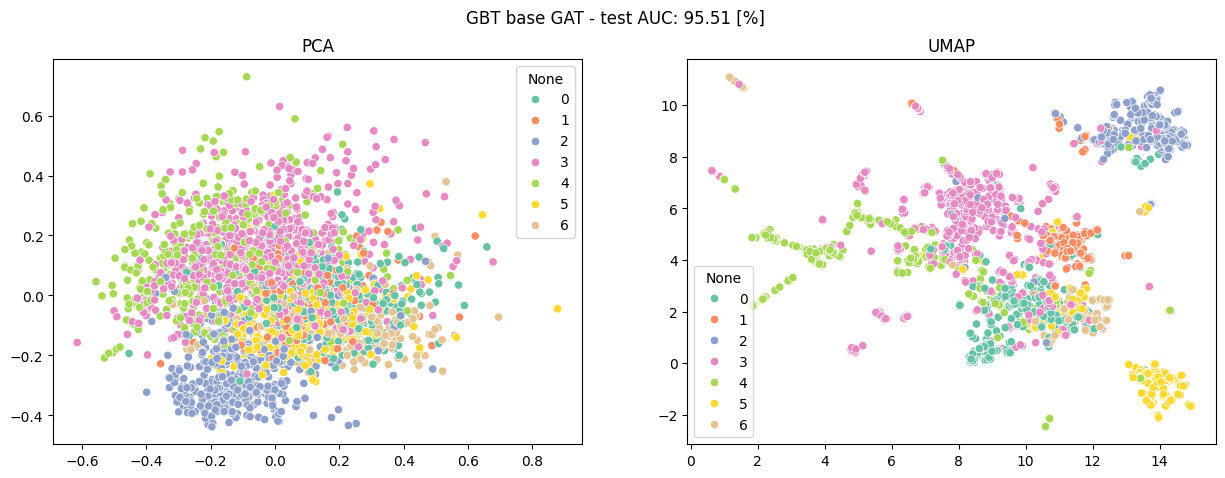

{'GCN': {'p_x': 0.1, 'p_e': 0.7, 'auc': 0.9613880574703216},
 'GraphSAGE': {'p_x': 0.9, 'p_e': 0.9, 'auc': 0.7798608303070068},
 'GAT': {'p_x': 0.3, 'p_e': 0.9, 'auc': 0.9550575613975525}}

In [49]:
no_batchnorm_res = eval_no_batchnorm(params=params)

display(no_batchnorm_res)



In [52]:
# combine results
combined_results = pd.DataFrame(params).T
combined_results["with batchnorm AUC"] = combined_results.pop("auc")
combined_results["without batchnorm AUC"] = pd.DataFrame(no_batchnorm_res).T["auc"]
display(combined_results)


,p_x,p_e,with batchnorm AUC,without batchnorm AUC
GCN,0.1,0.7,0.949669,0.961388
GraphSAGE,0.9,0.9,0.933485,0.779861
GAT,0.3,0.9,0.943370,0.955058
